In [1]:
###############################
####       Pre-reqs        ####
###############################

import numpy as np
import torch
from models import *
from torch_geometric.data import Data, DataLoader
from torch.autograd import Variable
from matplotlib import pyplot as plt
from os import listdir, remove
from os.path import join, isfile
import pickle
import shutil
import torch_geometric
import LJDataset
from tqdm import tqdm
from util import *
from time import sleep
%matplotlib inline
from random import random

#torch.ones(1).cuda()

print(torch.__version__)

n_f=2 # 30x2features
msg_dim = 100 # bottleneck
dim = 2 
hidden = 300 # arbitrary?
aggr='add'
edge_idx = 20*20 # fully connected graph
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


1.5.1


In [2]:
###############################
###  Gather and split data  ###
###############################

ta = 70 # Percentage used for training
te = 15 # Percentage used for testing (remaining used for validation)

try:
    shutil.rmtree("/tmp/LJs", ignore_errors=False, onerror=None)
except FileNotFoundError as e:
    pass
    
dataset = LJDataset.LJDataset(root='/tmp/LJs').shuffle()

train_data = dataset[0:int(ta/100.*len(dataset))]
test_data = dataset[int(ta/100.*len(dataset)):int((ta+te)/100.*len(dataset))]
validate_data = dataset[int((ta+te)/100.*len(dataset)):]

print(dataset[0])
#len(train_data), len(test_data), len(validate_data)
#print(train_data[0].edge_index[1][0:30])

Processing...
File: 0
File: 1
File: 2
File: 3
File: 4
File: 5
File: 6
File: 7
File: 8
File: 9
File: 10
File: 11
File: 12
File: 13
File: 14
File: 15
File: 16
File: 17
File: 18
File: 19
File: 20
File: 21
File: 22
File: 23
File: 24
File: 25
File: 26
File: 27
File: 28
File: 29
File: 30
File: 31
File: 32
File: 33
File: 34
File: 35
File: 36
File: 37
File: 38
File: 39
File: 40
File: 41
File: 42
File: 43
File: 44
File: 45
File: 46
File: 47
File: 48
File: 49
File: 50
File: 51


KeyboardInterrupt: 

In [3]:
def evaluate(mod, dataloader, device):
    
    mod.to(device)
    mod.eval()
    total_loss = 0.0
    num_items = 0
    
    for batch in dataloader:
        with torch.no_grad():
            batch.x = batch.x.to(device)
            batch.y = batch.y.to(device)
            batch.edge_index = batch.edge_index.to(device)
            batch.edge_attr = batch.edge_attr.to(device)
            batch.batch = batch.batch.to(device)

            pred = mod(batch.x, batch.edge_index)
            
            if len(pred) != len(batch.x):
                print("Error with sizes: batch.x --> " + str(len(batch.x)) + " and pred --> " + str(len(pred)))
            else:
                loss = mod.loss(batch.y.to('cpu'), pred.to('cpu'))

                total_loss += loss.item()
                num_items += int(batch.batch[-1]+1)

    return total_loss/num_items

n = 20 # number of agents
batch = int(64 * (4 / n)**2)
num_epochs = 200
num_models = 1
batch_per_epoch = int(100 / (batch/32.0))
recorded_models = []

trainLoader = DataLoader(train_data, batch_size=32, shuffle=True)
valLoader = DataLoader(validate_data, batch_size=32, shuffle=True)
testLoader = DataLoader(test_data, batch_size=32, shuffle=True)



import numpy as onp

for nm in range(num_models):

    onp.random.seed(nm)
    mod = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=edge_idx, aggr=aggr).to(device)
    data = train_data[0].to(device)    
    optimizer = torch.optim.Adam(mod.parameters(), lr=0.001, weight_decay=5e-8)
    mod.train()

    epoch = 0
    losses = []

    for epoch in tqdm(range(epoch, num_epochs)):

        mod.to(device)
        mod.train()

        total_loss = 0.0
        i = 0
        num_items = 0
        while i < batch_per_epoch:
            for ginput in trainLoader:
                if i >= batch_per_epoch:
                    break
                #print(i, " < ", batch_per_epoch)
                optimizer.zero_grad()
                ginput.x = ginput.x.to(device)
                ginput.y = ginput.y.to(device)
                ginput.edge_index = ginput.edge_index.to(device)
                ginput.edge_attr = ginput.edge_attr.to(device)
                ginput.batch = ginput.batch.to(device)

                pred = mod(ginput.x, ginput.edge_index)
                loss = mod.loss (ginput.y, pred)

                (loss/int(ginput.batch[-1]+1)).backward()
                optimizer.step()

                total_loss += loss.item()
                i += 1
                num_items += int(ginput.batch[-1]+1)


        cur_loss = total_loss/num_items
        train_loss = evaluate(mod, trainLoader, device)
        test_loss = evaluate(mod, testLoader, device)
        val_loss = evaluate(mod, valLoader, device)

        print("{during: " + str(cur_loss) + "}, {train: " + str(train_loss) +"}, {test: " + str(test_loss) + "}, {val: " + str(val_loss) + "}")
        losses.append([cur_loss, train_loss, test_loss, val_loss])

        sleep(0.5)
    
    mod.cpu()
    torch.save(mod.state_dict(), './models/MULTIMODELNUM'+str(nm)+'.mod')

  0%|          | 0/200 [00:00<?, ?it/s]

{during: 2.59964304174705}, {train: 2.577904410961368}, {test: 2.532539623841058}, {val: 2.5647713703474975}


  0%|          | 1/200 [01:42<5:38:27, 102.05s/it]

{during: 2.572661257715127}, {train: 2.5598079782508942}, {test: 2.517057652722159}, {val: 2.548396875067323}


  1%|          | 2/200 [03:25<5:37:54, 102.40s/it]

{during: 2.5448217652597642}, {train: 2.5362325792427525}, {test: 2.4938936416349793}, {val: 2.524416181458526}


  2%|▏         | 3/200 [05:08<5:37:23, 102.76s/it]

{during: 2.498659737327966}, {train: 2.47043038469447}, {test: 2.432737996596857}, {val: 2.4607430256059017}


  2%|▏         | 4/200 [06:55<5:39:55, 104.06s/it]

{during: 2.135504551853774}, {train: 1.969954620116207}, {test: 1.9512147379467955}, {val: 1.954599215453788}


  2%|▎         | 5/200 [08:39<5:37:21, 103.80s/it]

{during: 1.3635375541223056}, {train: 1.1296178757563036}, {test: 1.1296012897211594}, {val: 1.1293479684946954}


  3%|▎         | 6/200 [10:26<5:38:57, 104.83s/it]

{during: 1.1392748474024517}, {train: 1.0605772518523453}, {test: 1.0633507312154877}, {val: 1.0593254422702327}


  4%|▎         | 7/200 [12:12<5:38:47, 105.32s/it]

{during: 1.075781819615058}, {train: 0.9860327457027468}, {test: 0.9911134643652741}, {val: 0.9879671727137791}


  4%|▍         | 8/200 [14:02<5:40:49, 106.51s/it]

{during: 1.0430251079399184}, {train: 1.1753128820825294}, {test: 1.1748756332291237}, {val: 1.1794841467734194}


  4%|▍         | 9/200 [15:55<5:45:36, 108.57s/it]

{during: 1.0068050883127477}, {train: 0.9472101370219999}, {test: 0.9526540775223489}, {val: 0.9521030388033653}


  5%|▌         | 10/200 [18:37<6:34:04, 124.45s/it]

{during: 0.9901479866865573}, {train: 0.9117875981727552}, {test: 0.9181322859941515}, {val: 0.9184409511449327}


  6%|▌         | 11/200 [21:34<7:21:59, 140.31s/it]

{during: 0.9638592399842634}, {train: 0.9050247389355133}, {test: 0.9111095939980236}, {val: 0.9080650513829346}


  6%|▌         | 12/200 [24:39<8:01:52, 153.79s/it]

{during: 0.9512235974914333}, {train: 1.136989929102921}, {test: 1.1465416062857465}, {val: 1.1383281449583262}


  6%|▋         | 13/200 [27:46<8:29:54, 163.61s/it]

{during: 0.9391225855543918}, {train: 0.9252890205055013}, {test: 0.9334364663588103}, {val: 0.9305627638636474}


  7%|▋         | 14/200 [32:10<10:00:51, 193.82s/it]

{during: 0.9248299292514297}, {train: 0.8518046213960894}, {test: 0.8649267029351158}, {val: 0.8631409865473496}


  8%|▊         | 15/200 [37:09<11:35:10, 225.46s/it]

{during: 0.9158931459885655}, {train: 0.8530987696776223}, {test: 0.8657251555978122}, {val: 0.8638338577979687}


  8%|▊         | 16/200 [42:11<12:42:01, 248.48s/it]

{during: 0.9056838381854218}, {train: 1.0927580080453652}, {test: 1.1014060177434828}, {val: 1.0974776884247694}


  8%|▊         | 17/200 [47:23<13:35:54, 267.51s/it]

{during: 0.8929663006455636}, {train: 0.8713715264062668}, {test: 0.8830327085781189}, {val: 0.8811442380698035}


  9%|▉         | 18/200 [52:39<14:14:58, 281.86s/it]

{during: 0.8820851616929204}, {train: 0.8538348647362188}, {test: 0.8696265480586519}, {val: 0.8670213374164227}


 10%|▉         | 19/200 [58:01<14:47:13, 294.11s/it]

{during: 0.8778095092224978}, {train: 0.815498423836249}, {test: 0.8297310523051221}, {val: 0.8279286354148279}


 10%|█         | 20/200 [1:03:34<15:16:35, 305.53s/it]

{during: 0.871763693920971}, {train: 0.8360614810315481}, {test: 0.8511039892815415}, {val: 0.8474648533451605}


 10%|█         | 21/200 [1:09:15<15:44:05, 316.46s/it]

{during: 0.8636893085189783}, {train: 0.8569019677867441}, {test: 0.8733799754519962}, {val: 0.8718010730216426}


 11%|█         | 22/200 [1:15:04<16:07:16, 326.05s/it]

{during: 0.8557126983289657}, {train: 0.8766921585617021}, {test: 0.890540054041836}, {val: 0.8910588877031037}


 12%|█▏        | 23/200 [1:21:03<16:31:16, 336.02s/it]

{during: 0.8479626645835266}, {train: 0.7907277426443358}, {test: 0.8071798053098794}, {val: 0.8058663615579905}


 12%|█▏        | 24/200 [1:27:13<16:55:30, 346.19s/it]

{during: 0.8444212424501499}, {train: 0.8393517890006594}, {test: 0.8562924856034951}, {val: 0.853568467830381}


 12%|█▎        | 25/200 [1:33:35<17:20:41, 356.81s/it]

{during: 0.8374348414072091}, {train: 0.8232476406130241}, {test: 0.8392445583778619}, {val: 0.8377713476929836}


 13%|█▎        | 26/200 [1:40:05<17:43:58, 366.89s/it]

{during: 0.8367434425247442}, {train: 0.9234395854553817}, {test: 0.9391718250890354}, {val: 0.9310693873611552}


 14%|█▎        | 27/200 [1:46:41<18:02:50, 375.55s/it]

{during: 0.8302346786749705}, {train: 0.8990132077206706}, {test: 0.915886738934353}, {val: 0.9153358617158793}


 14%|█▍        | 28/200 [1:53:21<18:17:41, 382.92s/it]

{during: 0.8267833342487633}, {train: 0.7533510265251856}, {test: 0.773759113461708}, {val: 0.77258728188298}


 14%|█▍        | 29/200 [2:00:10<18:33:18, 390.64s/it]

{during: 0.819312057246224}, {train: 0.7882112548793108}, {test: 0.8097473925692348}, {val: 0.8067941457307627}


 15%|█▌        | 30/200 [2:07:06<18:49:05, 398.50s/it]

{during: 0.8154503048690018}, {train: 0.7593883016720901}, {test: 0.7796075346383827}, {val: 0.7783661023481266}


 16%|█▌        | 31/200 [2:14:05<18:59:04, 404.40s/it]

{during: 0.8142800083433512}, {train: 0.7738931874523064}, {test: 0.7959765395145798}, {val: 0.7915303591207151}


 16%|█▌        | 32/200 [2:21:07<19:07:29, 409.82s/it]

{during: 0.8041246393729131}, {train: 0.8729223415267515}, {test: 0.8896360821216817}, {val: 0.8834081060704084}


 16%|█▋        | 33/200 [2:28:13<19:13:57, 414.60s/it]

{during: 0.8030884171120926}, {train: 0.7598226764348479}, {test: 0.7799226608268196}, {val: 0.7789976048913801}


 17%|█▋        | 34/200 [2:35:22<19:19:29, 419.09s/it]

{during: 0.8038345894762585}, {train: 0.7263769603035468}, {test: 0.7485825135287297}, {val: 0.7469516381586254}


 18%|█▊        | 35/200 [2:42:32<19:21:19, 422.30s/it]

{during: 0.799690930535171}, {train: 0.8356832965406548}, {test: 0.8534120615051864}, {val: 0.8559528235629326}


 18%|█▊        | 36/200 [2:49:44<19:22:15, 425.21s/it]

{during: 0.798209986211928}, {train: 0.7302081149129162}, {test: 0.7527871296851886}, {val: 0.7500279461911108}


 18%|█▊        | 37/200 [2:57:01<19:24:33, 428.67s/it]

{during: 0.790116832087299}, {train: 0.7814943685000886}, {test: 0.8052797767939041}, {val: 0.8002494226612149}


 19%|█▉        | 38/200 [3:04:18<19:24:34, 431.33s/it]

{during: 0.7891752544806298}, {train: 0.7634871612303707}, {test: 0.7865869130492785}, {val: 0.7806575425459094}


 20%|█▉        | 39/200 [3:11:37<19:22:59, 433.41s/it]

{during: 0.7874304347280362}, {train: 0.8590129384813949}, {test: 0.8799129956741717}, {val: 0.8782183376924209}


 20%|██        | 40/200 [3:18:59<19:22:57, 436.11s/it]

{during: 0.7812832758953934}, {train: 0.8770826573243308}, {test: 0.8986452414594448}, {val: 0.898846355641672}


 20%|██        | 41/200 [3:26:20<19:19:34, 437.58s/it]

{during: 0.7856573087458234}, {train: 0.7146764111149537}, {test: 0.7394833163861686}, {val: 0.7359324641339042}


 21%|██        | 42/200 [3:33:45<19:18:18, 439.86s/it]

{during: 0.7809144965893139}, {train: 0.7646893287347913}, {test: 0.7906864889814318}, {val: 0.7840963609980985}


 22%|██▏       | 43/200 [3:41:11<19:15:19, 441.52s/it]

{during: 0.7756714102592721}, {train: 0.7375399520269975}, {test: 0.7616566244049578}, {val: 0.7603177532033457}


 22%|██▏       | 44/200 [3:48:39<19:13:30, 443.65s/it]

{during: 0.7744305631466143}, {train: 0.7334997079732154}, {test: 0.7604597391351408}, {val: 0.7568663018856346}


 22%|██▎       | 45/200 [3:56:07<19:08:49, 444.70s/it]

{during: 0.7686361071164143}, {train: 0.7580553965040547}, {test: 0.7846637410015471}, {val: 0.782016494335927}


 23%|██▎       | 46/200 [4:03:37<19:05:42, 446.38s/it]

{during: 0.7727099217606761}, {train: 0.7077415331710841}, {test: 0.7354235220634671}, {val: 0.7317179818560874}


 24%|██▎       | 47/200 [4:11:09<19:02:53, 448.19s/it]

{during: 0.7654077906563032}, {train: 0.711575242992933}, {test: 0.7375542817489102}, {val: 0.7325343805861744}


 24%|██▍       | 48/200 [4:18:41<18:58:20, 449.35s/it]

{during: 0.7618761306857782}, {train: 0.7278598905334648}, {test: 0.7535385341425709}, {val: 0.7512550063959458}


 24%|██▍       | 49/200 [4:26:15<18:54:28, 450.79s/it]

{during: 0.7637321967122536}, {train: 0.7380819847032521}, {test: 0.7666116979835349}, {val: 0.7607427563547807}


 25%|██▌       | 50/200 [4:33:51<18:50:22, 452.15s/it]

{during: 0.7597321324036309}, {train: 0.7016699231881488}, {test: 0.7320176670302846}, {val: 0.7249352256397436}


 26%|██▌       | 51/200 [4:41:26<18:44:59, 453.02s/it]

{during: 0.7608956690585932}, {train: 0.7272794354297071}, {test: 0.7543483628723138}, {val: 0.7496667944866678}


 26%|██▌       | 52/200 [4:49:01<18:39:13, 453.74s/it]

{during: 0.7542019639668449}, {train: 0.7355710175033281}, {test: 0.7618855662987831}, {val: 0.7575401507140891}


 26%|██▋       | 53/200 [4:56:37<18:33:18, 454.41s/it]

{during: 0.7523495421383805}, {train: 0.737115705865454}, {test: 0.768388710275278}, {val: 0.7645707868819932}


 27%|██▋       | 54/200 [5:04:15<18:28:03, 455.37s/it]

{during: 0.7533744958366848}, {train: 0.7912712093228522}, {test: 0.8192917959738866}, {val: 0.8167985945550653}


 28%|██▊       | 55/200 [5:11:50<18:20:39, 455.45s/it]

{during: 0.7529953460699321}, {train: 0.7949446139661184}, {test: 0.8197887310752447}, {val: 0.8128776895486713}


 28%|██▊       | 56/200 [5:19:28<18:14:19, 455.97s/it]

{during: 0.7541727951436409}, {train: 0.7899004919475614}, {test: 0.8201624884701929}, {val: 0.8163710302294488}


 28%|██▊       | 57/200 [5:27:07<18:08:51, 456.87s/it]

{during: 0.7453851945368893}, {train: 0.7033638682012509}, {test: 0.7315880673414534}, {val: 0.7299624942665974}


 29%|██▉       | 58/200 [5:34:47<18:03:28, 457.81s/it]

{during: 0.7485330212461124}, {train: 0.7953860318681254}, {test: 0.8203897428190835}, {val: 0.8178739178024949}


 30%|██▉       | 59/200 [5:42:27<17:57:20, 458.45s/it]

{during: 0.7434167007206637}, {train: 0.7496426846388764}, {test: 0.7784503774570426}, {val: 0.7731368154140529}


 30%|███       | 60/200 [5:50:06<17:50:32, 458.80s/it]

{during: 0.7437853504011079}, {train: 0.7220944348246081}, {test: 0.7511123850474052}, {val: 0.7463573121646662}


 30%|███       | 61/200 [5:57:49<17:45:22, 459.88s/it]

{during: 0.7359093228296723}, {train: 0.7885211725721945}, {test: 0.8148807246998852}, {val: 0.8140926553085239}


 31%|███       | 62/200 [6:05:30<17:39:00, 460.44s/it]

{during: 0.7459223626476903}, {train: 0.7294450292844439}, {test: 0.7601516709741872}, {val: 0.7578986001030029}


 32%|███▏      | 63/200 [6:13:13<17:33:06, 461.22s/it]

{during: 0.7341722285078488}, {train: 0.7340627179389293}, {test: 0.7629035924376494}, {val: 0.7616787276448772}


 32%|███▏      | 64/200 [6:20:56<17:26:18, 461.61s/it]

{during: 0.7370590247518466}, {train: 0.8787347580192422}, {test: 0.9048940871631842}, {val: 0.9021269844645069}


 32%|███▎      | 65/200 [6:28:40<17:20:19, 462.37s/it]

{during: 0.7368759954414175}, {train: 0.6861257568420656}, {test: 0.7179671194896308}, {val: 0.7140903466772691}


 33%|███▎      | 66/200 [6:36:22<17:12:40, 462.39s/it]

{during: 0.7395434077682923}, {train: 0.6822393966692313}, {test: 0.7132461386880081}, {val: 0.7113436351473006}


 34%|███▎      | 67/200 [6:44:04<17:04:40, 462.26s/it]

{during: 0.7306426844271122}, {train: 0.7456803673871687}, {test: 0.7751650620773363}, {val: 0.7744445898824444}


 34%|███▍      | 68/200 [6:51:48<16:58:10, 462.80s/it]

{during: 0.7305844577766131}, {train: 0.685149891339563}, {test: 0.7197081917318144}, {val: 0.7146278962662093}


 34%|███▍      | 69/200 [6:59:30<16:49:38, 462.43s/it]

{during: 0.7308238383761485}, {train: 0.6739419976528253}, {test: 0.7069342048287941}, {val: 0.7045552776007408}


 35%|███▌      | 70/200 [7:07:15<16:43:46, 463.28s/it]

{during: 0.734773084890104}, {train: 0.6844624167314837}, {test: 0.7188504672451372}, {val: 0.716121606587802}


 36%|███▌      | 71/200 [7:15:01<16:37:34, 463.99s/it]

{during: 0.72072116462967}, {train: 0.7206592256039364}, {test: 0.7512387317266481}, {val: 0.7503917148318018}


 36%|███▌      | 72/200 [7:22:46<16:30:21, 464.23s/it]

{during: 0.7286180589103636}, {train: 0.6954927052920807}, {test: 0.7280483721818584}, {val: 0.722274805397006}


 36%|███▋      | 73/200 [7:30:30<16:22:55, 464.38s/it]

{during: 0.7333856460691414}, {train: 0.7148180879427658}, {test: 0.7451998584081775}, {val: 0.7445401117974774}


 37%|███▋      | 74/200 [7:38:17<16:16:28, 464.99s/it]

{during: 0.7240899784557381}, {train: 0.6893016675116341}, {test: 0.7226301910050665}, {val: 0.7164693484344123}


 38%|███▊      | 75/200 [7:46:01<16:08:25, 464.85s/it]

{during: 0.7160829363843411}, {train: 0.7208276642073316}, {test: 0.7528320225477346}, {val: 0.7514905218752275}


 38%|███▊      | 76/200 [7:53:47<16:00:57, 464.98s/it]

{during: 0.7263202515217762}, {train: 0.700629069798306}, {test: 0.7376257351101805}, {val: 0.7338008457803961}


 38%|███▊      | 77/200 [8:01:34<15:54:50, 465.77s/it]

{during: 0.7245668449371303}, {train: 0.7382549854482102}, {test: 0.7718824064040881}, {val: 0.7697193285054991}


 39%|███▉      | 78/200 [8:09:21<15:47:47, 466.13s/it]

{during: 0.7149816756067673}, {train: 0.664390417964583}, {test: 0.7003839220494571}, {val: 0.6963339577039832}


 40%|███▉      | 79/200 [8:17:06<15:39:09, 465.70s/it]

{during: 0.7260667305315343}, {train: 0.6649296762857092}, {test: 0.6987644143261337}, {val: 0.6975930518883406}


 40%|████      | 80/200 [8:24:54<15:32:32, 466.27s/it]

{during: 0.7211193252309814}, {train: 0.7098612191248952}, {test: 0.7424918525387749}, {val: 0.7407733692962523}


 40%|████      | 81/200 [8:32:39<15:24:28, 466.12s/it]

{during: 0.7184292447003204}, {train: 0.7266650921574832}, {test: 0.7592319671558954}, {val: 0.7556504480178516}


 41%|████      | 82/200 [8:40:26<15:17:14, 466.40s/it]

{during: 0.7126780858305981}, {train: 0.8904081644221277}, {test: 0.9174766681479529}, {val: 0.9120441045820343}


 42%|████▏     | 83/200 [8:48:13<15:09:36, 466.47s/it]

{during: 0.7151615126018253}, {train: 0.7488453673440973}, {test: 0.7803255356748494}, {val: 0.781302458827872}


 42%|████▏     | 84/200 [8:56:02<15:03:34, 467.36s/it]

{during: 0.707684519309973}, {train: 0.7585327097005838}, {test: 0.7934844548255126}, {val: 0.7917213685049391}


 42%|████▎     | 85/200 [9:03:49<14:55:16, 467.10s/it]

{during: 0.7157743000010323}, {train: 0.7185464332654978}, {test: 0.7540803764059724}, {val: 0.7524228229796409}


 43%|████▎     | 86/200 [9:11:39<14:48:55, 467.86s/it]

{during: 0.7152618775506808}, {train: 0.6647007696969168}, {test: 0.6992165640154525}, {val: 0.698220442132384}


 44%|████▎     | 87/200 [9:19:26<14:41:00, 467.80s/it]

{during: 0.7097742290421934}, {train: 0.6657538259815909}, {test: 0.7016788200557366}, {val: 0.6969801111684976}


 44%|████▍     | 88/200 [9:27:15<14:33:33, 467.98s/it]

{during: 0.7131171429472333}, {train: 0.6600583800788044}, {test: 0.6968250989633058}, {val: 0.6947571546522293}


 44%|████▍     | 89/200 [9:35:05<14:26:51, 468.58s/it]

{during: 0.7067923846614332}, {train: 0.8222212627627559}, {test: 0.8517236183577512}, {val: 0.8462097378761617}


 45%|████▌     | 90/200 [9:42:52<14:18:13, 468.12s/it]

{during: 0.7115581832174533}, {train: 0.6643006617709678}, {test: 0.7000588948892374}, {val: 0.6962576271967297}


 46%|████▌     | 91/200 [9:50:42<14:11:53, 468.93s/it]

{during: 0.7067487929463538}, {train: 0.7484376913695518}, {test: 0.7808102187628254}, {val: 0.7753306576975358}


 46%|████▌     | 92/200 [9:58:31<14:03:57, 468.87s/it]

{during: 0.7108646183498661}, {train: 0.7596824447710625}, {test: 0.7910414386564191}, {val: 0.7874585615539224}


 46%|████▋     | 93/200 [10:06:19<13:55:47, 468.67s/it]

{during: 0.7038335305924261}, {train: 0.6690894687059482}, {test: 0.7039858781386203}, {val: 0.7003213221063245}


 47%|████▋     | 94/200 [10:14:09<13:48:14, 468.82s/it]

{during: 0.7027074058929006}, {train: 0.676307575424991}, {test: 0.7134963873431887}, {val: 0.7097601048005268}


 48%|████▊     | 95/200 [10:21:59<13:41:19, 469.32s/it]

{during: 0.7064494329557847}, {train: 0.6865682261385455}, {test: 0.7221239213962888}, {val: 0.7196101129220982}


 48%|████▊     | 96/200 [10:29:50<13:34:05, 469.67s/it]

{during: 0.7005059893040763}, {train: 0.6603729093095316}, {test: 0.6993155459513996}, {val: 0.6933267115014706}


 48%|████▊     | 97/200 [10:37:40<13:26:45, 469.96s/it]

{during: 0.7070031764184022}, {train: 0.6775995990974221}, {test: 0.7146779424285971}, {val: 0.713495848290694}


 49%|████▉     | 98/200 [10:45:31<13:19:30, 470.30s/it]

{during: 0.7063985316999439}, {train: 0.6930527231519549}, {test: 0.7249830337284182}, {val: 0.7240231518674953}


 50%|████▉     | 99/200 [10:53:22<13:11:39, 470.30s/it]

{during: 0.7010712938531714}, {train: 0.657665759429669}, {test: 0.695346276433511}, {val: 0.6947382156689077}


 50%|█████     | 100/200 [11:01:10<13:02:46, 469.67s/it]

{during: 0.6987762924925813}, {train: 0.6630670953686048}, {test: 0.6997902624941847}, {val: 0.6968970093489153}


 50%|█████     | 101/200 [11:09:00<12:55:02, 469.72s/it]

{during: 0.7066311249126853}, {train: 0.7335604023892375}, {test: 0.7686583500699005}, {val: 0.7627872355516883}


 51%|█████     | 102/200 [11:16:52<12:48:34, 470.55s/it]

{during: 0.693271350232774}, {train: 0.6546731644202017}, {test: 0.6917720940532605}, {val: 0.6888695504635247}


 52%|█████▏    | 103/200 [11:24:46<12:42:07, 471.42s/it]

{during: 0.6974292043359632}, {train: 0.6645367394872459}, {test: 0.7031928056617027}, {val: 0.6996324953417065}


 52%|█████▏    | 104/200 [11:32:35<12:33:21, 470.85s/it]

{during: 0.692799204673051}, {train: 0.7394234422343391}, {test: 0.7715338908899542}, {val: 0.7674769097003622}


 52%|█████▎    | 105/200 [11:40:28<12:26:42, 471.61s/it]

{during: 0.6965437341925431}, {train: 0.744211632733501}, {test: 0.7798184877648731}, {val: 0.7744318442672498}


 53%|█████▎    | 106/200 [11:48:21<12:19:19, 471.91s/it]

{during: 0.6984552261323625}, {train: 0.6368090568844504}, {test: 0.6760965310315625}, {val: 0.6738999522608081}


 54%|█████▎    | 107/200 [11:56:14<12:11:46, 472.11s/it]

{during: 0.6958763654027424}, {train: 0.6392732586097389}, {test: 0.681313165495326}, {val: 0.6769317413300665}


 54%|█████▍    | 108/200 [12:04:07<12:04:38, 472.59s/it]

{during: 0.6901704329879482}, {train: 0.6689691536575642}, {test: 0.7080486880209789}, {val: 0.7069775206957417}


 55%|█████▍    | 109/200 [12:12:01<11:57:16, 472.93s/it]

{during: 0.6919929449213282}, {train: 0.6358552794639776}, {test: 0.6780977027503303}, {val: 0.6723455851684165}


 55%|█████▌    | 110/200 [12:19:56<11:50:20, 473.56s/it]

{during: 0.689463856560657}, {train: 0.7008713269083239}, {test: 0.7374936014244665}, {val: 0.733726487779648}


 56%|█████▌    | 111/200 [12:27:49<11:42:03, 473.30s/it]

{during: 0.6975918342638173}, {train: 0.7411255308929285}, {test: 0.7780103322920074}, {val: 0.7714374376379926}


 56%|█████▌    | 112/200 [12:35:41<11:33:50, 473.07s/it]

{during: 0.6878266315624519}, {train: 0.8039734598007684}, {test: 0.8381434597192287}, {val: 0.8370649221750776}


 56%|█████▋    | 113/200 [12:43:36<11:26:37, 473.54s/it]

{during: 0.6878304042683145}, {train: 0.6465342609539021}, {test: 0.6870402866938365}, {val: 0.6860877245594383}


 57%|█████▋    | 114/200 [12:51:31<11:19:28, 474.05s/it]

{during: 0.698936879484655}, {train: 0.8644459150689673}, {test: 0.8952352875775618}, {val: 0.8940051473624498}


 57%|█████▊    | 115/200 [12:59:26<11:11:45, 474.18s/it]

{during: 0.6999735790204322}, {train: 0.659451592051976}, {test: 0.699083706775186}, {val: 0.6949324104356469}


 58%|█████▊    | 116/200 [13:07:20<11:03:53, 474.21s/it]

{during: 0.6864823010896915}, {train: 0.6327876195070461}, {test: 0.6734361159312492}, {val: 0.6709646509709362}


 58%|█████▊    | 117/200 [13:15:14<10:55:51, 474.12s/it]

{during: 0.6933480509022699}, {train: 0.7190920714981858}, {test: 0.7560654575135042}, {val: 0.7504804355476724}


 59%|█████▉    | 118/200 [13:23:09<10:48:29, 474.51s/it]

{during: 0.6799812628756149}, {train: 0.6951875097698271}, {test: 0.7303514107782504}, {val: 0.7301869460820999}


 60%|█████▉    | 119/200 [13:31:06<10:41:17, 475.03s/it]

{during: 0.6939687643743987}, {train: 0.633255672925379}, {test: 0.6743566231769987}, {val: 0.6701599457300202}


 60%|██████    | 120/200 [13:39:01<10:33:41, 475.27s/it]

{during: 0.6831730280177526}, {train: 0.6821254782093987}, {test: 0.7228873788997654}, {val: 0.7198161169915313}


 60%|██████    | 121/200 [13:46:59<10:26:34, 475.88s/it]

{during: 0.68469711116743}, {train: 0.6690337976312336}, {test: 0.711811729170493}, {val: 0.7058204802845857}


 61%|██████    | 122/200 [13:54:55<10:18:57, 476.13s/it]

{during: 0.6885835144915734}, {train: 0.6757736020025275}, {test: 0.7146332716168129}, {val: 0.7091014504202889}


 62%|██████▏   | 123/200 [14:02:51<10:10:53, 476.02s/it]

{during: 0.6844512705240207}, {train: 0.6385166610087462}, {test: 0.6818483411289071}, {val: 0.6790460519960182}


 62%|██████▏   | 124/200 [14:10:47<10:02:54, 475.99s/it]

{during: 0.6838328927538203}, {train: 0.7057237435153211}, {test: 0.7448960179956768}, {val: 0.7409924925662997}


 62%|██████▎   | 125/200 [14:18:43<9:54:59, 475.99s/it] 

{during: 0.688585102005066}, {train: 0.656669341244372}, {test: 0.6970402940356069}, {val: 0.6946531683046983}


 63%|██████▎   | 126/200 [14:26:41<9:47:36, 476.44s/it]

{during: 0.6820021513996861}, {train: 0.6366621972334091}, {test: 0.6795791736491247}, {val: 0.6758146618949088}


 64%|██████▎   | 127/200 [14:34:37<9:39:37, 476.41s/it]

{during: 0.682332219121996}, {train: 0.6964739670044926}, {test: 0.7369605766395257}, {val: 0.7345710966004425}


 64%|██████▍   | 128/200 [14:42:33<9:31:27, 476.21s/it]

{during: 0.6786996126198214}, {train: 0.7460632852323426}, {test: 0.7857819430843671}, {val: 0.7819827241748476}


 64%|██████▍   | 129/200 [14:50:29<9:23:25, 476.13s/it]

{during: 0.6773972329931119}, {train: 0.7348573806596364}, {test: 0.7697983880976071}, {val: 0.76720241919195}


 65%|██████▌   | 130/200 [14:58:26<9:15:54, 476.49s/it]

{during: 0.6816058831500778}, {train: 0.6269040747121087}, {test: 0.670826341887032}, {val: 0.6670160095450147}


 66%|██████▌   | 131/200 [15:06:22<9:07:48, 476.36s/it]

{during: 0.6817951909763283}, {train: 0.702063126512047}, {test: 0.7405484228020781}, {val: 0.7400572955110493}


 66%|██████▌   | 132/200 [15:14:17<8:59:33, 476.08s/it]

{during: 0.6797006715145336}, {train: 0.6603068536571299}, {test: 0.7036300557857537}, {val: 0.69864010295104}


 66%|██████▋   | 133/200 [15:22:14<8:51:52, 476.31s/it]

{during: 0.6828667342293709}, {train: 0.7664416460134623}, {test: 0.8012338002795157}, {val: 0.7951350070138794}


 67%|██████▋   | 134/200 [15:30:13<8:44:43, 477.02s/it]

{during: 0.6747146230199361}, {train: 0.6827060622424828}, {test: 0.7229358106835618}, {val: 0.7180347467137752}


 68%|██████▊   | 135/200 [15:38:16<8:38:52, 478.97s/it]

{during: 0.6769079231586662}, {train: 0.6494115771908084}, {test: 0.690782240374997}, {val: 0.6870288763089158}


 68%|██████▊   | 136/200 [15:46:14<8:30:23, 478.49s/it]

{during: 0.6739634246909633}, {train: 0.6349369583961544}, {test: 0.6766440839012647}, {val: 0.672224709144571}


 68%|██████▊   | 137/200 [15:54:11<8:22:06, 478.20s/it]

{during: 0.6784529937754872}, {train: 0.6870895588842535}, {test: 0.726281181091132}, {val: 0.7217835258635854}


 69%|██████▉   | 138/200 [16:02:09<8:13:55, 477.99s/it]

{during: 0.6742486738003122}, {train: 0.6334002953210373}, {test: 0.6797118003610703}, {val: 0.673214371338675}


 70%|██████▉   | 139/200 [16:08:25<7:34:54, 447.44s/it]

{during: 0.6711376325288322}, {train: 0.6496747167809421}, {test: 0.6970703801774769}, {val: 0.6909348481113534}


 70%|███████   | 140/200 [16:14:16<6:58:38, 418.65s/it]

{during: 0.6718216118433725}, {train: 0.6265565836737366}, {test: 0.6700514764490584}, {val: 0.6670223884803117}


 70%|███████   | 141/200 [16:20:08<6:31:59, 398.64s/it]

{during: 0.670236933925544}, {train: 0.6244665159662086}, {test: 0.6691296236206329}, {val: 0.6652036723244954}


 71%|███████   | 142/200 [16:26:00<6:11:38, 384.46s/it]

{during: 0.6737192232957963}, {train: 0.6999502915400441}, {test: 0.7420000219493195}, {val: 0.7389318452297071}


 72%|███████▏  | 143/200 [16:31:53<5:56:14, 374.98s/it]

{during: 0.6665143270295637}, {train: 0.6875343495214116}, {test: 0.7273248909652724}, {val: 0.72349739503646}


 72%|███████▏  | 144/200 [16:37:45<5:43:47, 368.34s/it]

{during: 0.6721234069440893}, {train: 0.6205489821004512}, {test: 0.6638378148621789}, {val: 0.6604620095467665}


 72%|███████▎  | 145/200 [16:43:39<5:33:35, 363.91s/it]

{during: 0.6767581555105197}, {train: 0.7536183885671732}, {test: 0.7906769324232503}, {val: 0.7846968494153017}


 73%|███████▎  | 146/200 [16:49:34<5:25:00, 361.11s/it]

{during: 0.6696427820650603}, {train: 0.6821072166429739}, {test: 0.723061932247865}, {val: 0.7217819404234389}


 74%|███████▎  | 147/200 [16:55:26<5:16:39, 358.48s/it]

{during: 0.6621745803459519}, {train: 0.6307884243447003}, {test: 0.6756131169218137}, {val: 0.672366436198274}


 74%|███████▍  | 148/200 [17:01:18<5:09:00, 356.55s/it]

{during: 0.6705670823704577}, {train: 0.6011788749585395}, {test: 0.6471176180145503}, {val: 0.6438121358545058}


 74%|███████▍  | 149/200 [17:07:10<5:01:59, 355.28s/it]

{during: 0.6727346251987139}, {train: 0.6525803578782204}, {test: 0.6973997883971861}, {val: 0.6941602514499412}


 75%|███████▌  | 150/200 [17:13:03<4:55:16, 354.34s/it]

{during: 0.6677744735698696}, {train: 0.636622814171901}, {test: 0.6799902031939252}, {val: 0.6764032333661617}


 76%|███████▌  | 151/200 [17:18:57<4:49:26, 354.43s/it]

{during: 0.6660577538344555}, {train: 0.620589035984024}, {test: 0.6635812118169109}, {val: 0.6607042499721165}


 76%|███████▌  | 152/200 [17:24:51<4:43:24, 354.25s/it]

{during: 0.6652529914842394}, {train: 0.6908015416069272}, {test: 0.7304408110297568}, {val: 0.7270835393193601}


 76%|███████▋  | 153/200 [17:30:45<4:37:33, 354.33s/it]

{during: 0.6657745542185507}, {train: 0.648831852307213}, {test: 0.6916391065854313}, {val: 0.6895918671490933}


 77%|███████▋  | 154/200 [17:36:38<4:31:12, 353.76s/it]

{during: 0.660601143530423}, {train: 0.6434762997608108}, {test: 0.6867356330485087}, {val: 0.6845526263248642}


 78%|███████▊  | 155/200 [17:42:32<4:25:28, 353.97s/it]

{during: 0.6585640587135753}, {train: 0.6409905428073903}, {test: 0.6851195986730276}, {val: 0.6795096275867193}


 78%|███████▊  | 156/200 [17:48:25<4:19:11, 353.44s/it]

{during: 0.6696972280734333}, {train: 0.7214661821331434}, {test: 0.7626324690702041}, {val: 0.7572186313366884}


 78%|███████▊  | 157/200 [17:54:18<4:13:21, 353.53s/it]

{during: 0.6647170846059056}, {train: 0.8219645124950836}, {test: 0.8582474098887857}, {val: 0.8559449651966924}


 79%|███████▉  | 158/200 [18:00:14<4:07:54, 354.14s/it]

{during: 0.6692103979673298}, {train: 0.6473335132390962}, {test: 0.6924259878908067}, {val: 0.6883162902698039}


 80%|███████▉  | 159/200 [18:06:08<4:01:59, 354.13s/it]

{during: 0.661134993817387}, {train: 0.8782204544934061}, {test: 0.9138536405241616}, {val: 0.9068320722287869}


 80%|████████  | 160/200 [18:12:02<3:56:02, 354.06s/it]

{during: 0.6625530972981634}, {train: 0.594980093430187}, {test: 0.6438039748204193}, {val: 0.6390674292441225}


 80%|████████  | 161/200 [18:17:56<3:50:06, 354.02s/it]

{during: 0.6597273144881548}, {train: 0.6242109791574572}, {test: 0.6703079111688178}, {val: 0.6664525110886526}


 81%|████████  | 162/200 [18:23:52<3:44:42, 354.82s/it]

{during: 0.6620224446360424}, {train: 0.6541323756241484}, {test: 0.6964246247965582}, {val: 0.6936644298613109}


 82%|████████▏ | 163/200 [18:29:48<3:38:53, 354.97s/it]

{during: 0.6638637027314603}, {train: 0.7035845430322714}, {test: 0.7424542471085012}, {val: 0.7394730569361926}


 82%|████████▏ | 164/200 [18:35:43<3:33:04, 355.13s/it]

{during: 0.6635879756105323}, {train: 0.6376929372545638}, {test: 0.6807635543151574}, {val: 0.6790693846420905}


 82%|████████▎ | 165/200 [18:41:40<3:27:24, 355.55s/it]

{during: 0.6583525067892565}, {train: 0.6143506677466702}, {test: 0.6592919613291853}, {val: 0.6579116333932686}


 83%|████████▎ | 166/200 [18:47:37<3:21:41, 355.93s/it]

{during: 0.6573977414043027}, {train: 0.7144700749058595}, {test: 0.7577403849805717}, {val: 0.7540326086809457}


 84%|████████▎ | 167/200 [18:53:33<3:15:54, 356.19s/it]

{during: 0.6611425393036312}, {train: 0.8211752456778846}, {test: 0.8559287100746275}, {val: 0.8548379470357856}


 84%|████████▍ | 168/200 [18:59:30<3:09:58, 356.20s/it]

{during: 0.6637672885886504}, {train: 0.6127310102312851}, {test: 0.6593170686925875}, {val: 0.6559228442623672}


 84%|████████▍ | 169/200 [19:05:28<3:04:17, 356.69s/it]

{during: 0.6580373427547971}, {train: 0.643164246931749}, {test: 0.6880150247822868}, {val: 0.685639687793672}


 85%|████████▌ | 170/200 [19:11:24<2:58:14, 356.48s/it]

{during: 0.6591932671732059}, {train: 0.6743361747859883}, {test: 0.7220444966782285}, {val: 0.7154543783302658}


 86%|████████▌ | 171/200 [19:17:22<2:52:36, 357.13s/it]

{during: 0.6534949975560422}, {train: 0.6236694272906358}, {test: 0.6697935923731301}, {val: 0.6670487320737171}


 86%|████████▌ | 172/200 [19:23:18<2:46:32, 356.87s/it]

{during: 0.6585106337073492}, {train: 0.6108665612286969}, {test: 0.6600549269299621}, {val: 0.6553939783386766}


 86%|████████▋ | 173/200 [19:29:14<2:40:27, 356.59s/it]

{during: 0.6564737501660639}, {train: 0.7081077980352283}, {test: 0.7484999572208074}, {val: 0.743922591030687}


 87%|████████▋ | 174/200 [19:35:09<2:34:14, 355.94s/it]

{during: 0.6607324150274578}, {train: 0.700644601481575}, {test: 0.7439706129678966}, {val: 0.7413741800304551}


 88%|████████▊ | 175/200 [19:41:07<2:28:32, 356.52s/it]

{during: 0.650684265776389}, {train: 0.6262000312739519}, {test: 0.6752963913346277}, {val: 0.6681500831337653}


 88%|████████▊ | 176/200 [19:47:03<2:22:38, 356.59s/it]

{during: 0.6564049493202054}, {train: 0.7115649299818554}, {test: 0.7543657130649645}, {val: 0.7492937064318923}


 88%|████████▊ | 177/200 [19:53:02<2:16:53, 357.11s/it]

{during: 0.6601282532660229}, {train: 0.6630478947038153}, {test: 0.7061184657083482}, {val: 0.7047804221526844}


 89%|████████▉ | 178/200 [19:58:58<2:10:51, 356.87s/it]

{during: 0.6527193168791708}, {train: 0.6521482828548429}, {test: 0.6957954555044494}, {val: 0.6930659803340256}


 90%|████████▉ | 179/200 [20:04:56<2:05:01, 357.19s/it]

{during: 0.6531250862519066}, {train: 0.6327605830863913}, {test: 0.6822213939672059}, {val: 0.67706879141704}


 90%|█████████ | 180/200 [20:10:52<1:58:56, 356.83s/it]

{during: 0.650045754823772}, {train: 0.684357215675621}, {test: 0.7265921980126634}, {val: 0.7221702837949138}


 90%|█████████ | 181/200 [20:16:48<1:52:57, 356.71s/it]

{during: 0.6574494761913553}, {train: 0.8830920513019572}, {test: 0.918484259126681}, {val: 0.9170366114838829}


 91%|█████████ | 182/200 [20:22:46<1:47:04, 356.89s/it]

{during: 0.6511783611590243}, {train: 0.694617422413566}, {test: 0.737779193431621}, {val: 0.7347179998241367}


 92%|█████████▏| 183/200 [20:28:43<1:41:07, 356.90s/it]

{during: 0.6577457083440358}, {train: 0.7181198763560099}, {test: 0.7587458216379245}, {val: 0.7533549267721268}


 92%|█████████▏| 184/200 [20:34:41<1:35:18, 357.40s/it]

{during: 0.6463333838073226}, {train: 0.7054414102419724}, {test: 0.7495790381266625}, {val: 0.7469469900942125}


 92%|█████████▎| 185/200 [20:40:37<1:29:14, 356.97s/it]

{during: 0.6611805064621697}, {train: 0.6644219034865746}, {test: 0.71035101531953}, {val: 0.7070227500636104}


 93%|█████████▎| 186/200 [20:46:37<1:23:29, 357.84s/it]

{during: 0.6533562822165495}, {train: 0.6525164269443496}, {test: 0.6951460935860869}, {val: 0.6910564500633464}


 94%|█████████▎| 187/200 [20:52:36<1:17:34, 358.07s/it]

{during: 0.6479103845453722}, {train: 0.6435379518124815}, {test: 0.6885164987482988}, {val: 0.6856139853619028}


 94%|█████████▍| 188/200 [20:58:33<1:11:35, 357.97s/it]

{during: 0.6598918307130511}, {train: 0.6621764389537083}, {test: 0.7066550631204969}, {val: 0.7022707267756328}


 94%|█████████▍| 189/200 [21:04:32<1:05:40, 358.20s/it]

{during: 0.649134963193694}, {train: 0.6185863383911974}, {test: 0.664582148626809}, {val: 0.6600245702289672}


 95%|█████████▌| 190/200 [21:10:30<59:41, 358.14s/it]  

{during: 0.6524751739813442}, {train: 0.8757247685373889}, {test: 0.9084489711464454}, {val: 0.9099907514548041}


 96%|█████████▌| 191/200 [21:16:31<53:50, 358.94s/it]

{during: 0.6446439220627209}, {train: 0.6138677829473236}, {test: 0.6614385802804293}, {val: 0.6593094668671262}


 96%|█████████▌| 192/200 [21:22:31<47:53, 359.14s/it]

{during: 0.6508017982415396}, {train: 0.7603508323017236}, {test: 0.801412571979256}, {val: 0.797178203070488}


 96%|█████████▋| 193/200 [21:28:29<41:52, 358.91s/it]

{during: 0.6501031443288924}, {train: 0.6173532372374543}, {test: 0.6669644231878997}, {val: 0.6638598959868254}


 97%|█████████▋| 194/200 [21:34:26<35:50, 358.47s/it]

{during: 0.6508502728823878}, {train: 0.6888873403946422}, {test: 0.7317891823118091}, {val: 0.7287528084391163}


 98%|█████████▊| 195/200 [21:40:25<29:52, 358.47s/it]

{during: 0.6426760449649529}, {train: 0.6841192951957453}, {test: 0.7289989004046271}, {val: 0.7263853022464467}


 98%|█████████▊| 196/200 [21:46:22<23:52, 358.15s/it]

{during: 0.6512033626615042}, {train: 0.6484822004387177}, {test: 0.6956966882652372}, {val: 0.6941987659824459}


 98%|█████████▊| 197/200 [21:52:21<17:55, 358.40s/it]

{during: 0.649776192614595}, {train: 0.5998639816397986}, {test: 0.6496560691293384}, {val: 0.6469863784162563}


 99%|█████████▉| 198/200 [21:58:20<11:57, 358.61s/it]

{during: 0.6510409461185346}, {train: 0.6153844702059144}, {test: 0.664244748316039}, {val: 0.6621555327143601}


100%|█████████▉| 199/200 [22:04:20<05:58, 358.80s/it]

{during: 0.6456561168576685}, {train: 0.745483125477636}, {test: 0.7859588605478921}, {val: 0.7820185197449058}


100%|██████████| 200/200 [22:10:18<00:00, 399.09s/it]


(0.0, 3.3)

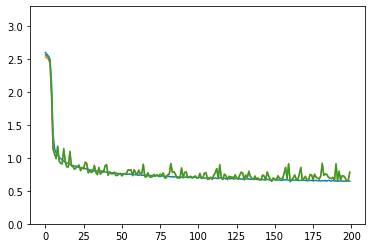

In [4]:
plt.plot([i for i in range(len(losses))],[losses[i][0] for i in range(len(losses))])
#plt.plot([i for i in range(len(losses))],[losses[i][1] for i in range(len(losses))])
plt.plot([i for i in range(len(losses))],[losses[i][2] for i in range(len(losses))])
plt.plot([i for i in range(len(losses))],[losses[i][3] for i in range(len(losses))])
plt.ylim([0,3.3])


In [3]:
mod = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=edge_idx, aggr=aggr).to(device)
mod.load_state_dict(torch.load('./models/MULTIMODELNUM0.mod'))
mod.eval()

OGN(
  (msg_fnc): Sequential(
    (0): Linear(in_features=4, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=100, bias=True)
  )
  (node_fnc): Sequential(
    (0): Linear(in_features=102, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=2, bias=True)
  )
)

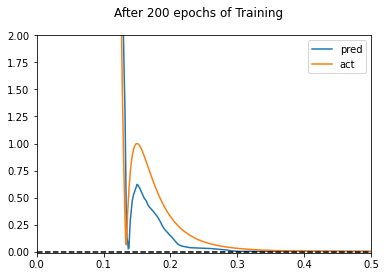

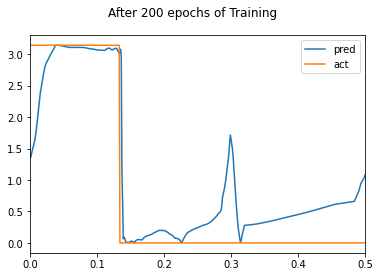

In [3]:
import math

mod.to('cpu')


MULT = 1
TARGET_DIST = 0.15 
DIP = 1 


def lj(x, e):
    
    dist = math.sqrt(((x[1][0]-x[0][0])**2)+((x[1][1]-x[0][1])**2))
    epsilon = DIP*MULT
    sigma = (TARGET_DIST*MULT)/(2**(1/6))
    mag = min((epsilon*4) * (pow((sigma/dist),12)-pow((sigma/dist),6)), 10)
    
    angle = 0
    if mag > 0:
        angle = math.pi
    
    return mag, angle
    
    

numPoints = 1000
delta = (1*MULT)/numPoints

plotDataX = []
plotDataPredY = []
plotDataPredA = []
plotDataActY = []
plotDataActA = []

for i in range(numPoints):
    
    data = [[0, 0] for _ in range(30)]
    data[1] = [delta*i+delta, 0]
    plotDataX.append(delta*i+delta)
    
    #print(data[1][0])
    
    e1 = [0, 1]
    e2 = [1, 0]
    
    x = torch.tensor(data, dtype=torch.float)
    e = torch.tensor([e1, e2], dtype=torch.long)
    
    pred = mod(x, e)
    actualMag, actualAng = lj(x, e)
    
    mag = math.sqrt(pred[0][0]**2+pred[0][1]**2)
    plotDataPredY.append(mag)
    
    a = math.atan2(pred[0][1], pred[0][0])%(2*math.pi)
    if a > math.pi:
        a = -(a-math.pi) + math.pi
    plotDataPredA.append(a)
    
    plotDataActY.append(abs(actualMag))
    plotDataActA.append(actualAng)
    
fig, ax1 = plt.subplots(1)
fig.suptitle('After 200 epochs of Training')

xs = 0
xe = 0.5#1 * MULT
ys = -0.01 * MULT
ye = 2*MULT


ax1.plot(plotDataX, plotDataPredY, label='pred')
ax1.plot(plotDataX, plotDataActY, label='act')

ax1.plot([xs, xe], [0, 0], 'k--')
ax1.plot([xs, TARGET_DIST], [-DIP, -DIP], 'k--')
ax1.plot([TARGET_DIST, TARGET_DIST], [ys, -DIP], 'k--')


ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.legend()




fig, ax2 = plt.subplots(1)
fig.suptitle('After 200 epochs of Training')
ax2.plot(plotDataX, plotDataPredA, label='pred')
ax2.plot(plotDataX, plotDataActA, label='act')
ax2.set_xlim([xs, xe])
ax2.legend()
    

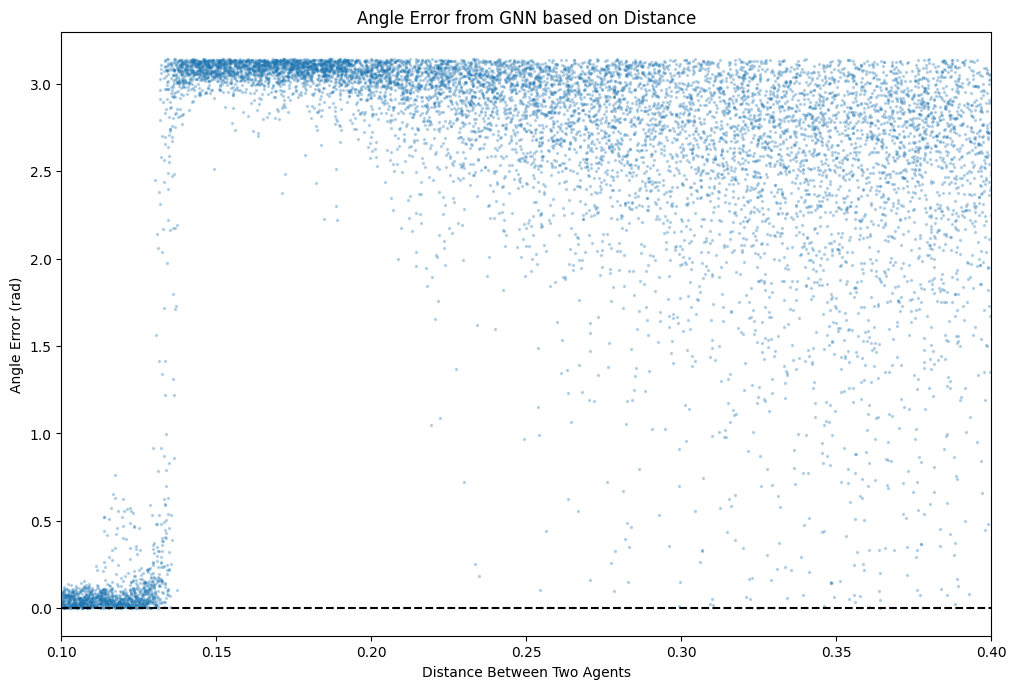

In [21]:
datapoints = 10000
from random import random

dataFileName = 'randomData.csv'
dataString = ''

MULT = 1
TARGET_DIST = 0.15 
DIP = 1 


def lj(x, e):
    
    dist = math.sqrt(((x[1][0]-x[0][0])**2)+((x[1][1]-x[0][1])**2))
    epsilon = DIP*MULT
    sigma = (TARGET_DIST*MULT)/(2**(1/6))
    mag = min((epsilon*4) * (pow((sigma/dist),12)-pow((sigma/dist),6)), 10)
    
    angle = 0
    if mag < 0:
        angle = math.pi
    
    return mag, angle

minDist = 0.1
maxDist = 0.4

mod.eval()

mod.to('cpu')

scatterX = []
scatterY = []
scatterA = []
scatterAA = []
scatterAY = []

scatterY2 = []

ljX = []
ljY = []
for i in range(1000):
    delta = (maxDist-minDist)/1000
    ljX.append(minDist + (i*delta))
    m,a = lj([[0, 0], [ljX[-1], 0]], [])
    ljY.append(m)

for i in range(datapoints):
    
    data = [[0, 0] for _ in range(7)]
    
    ox = random()
    oy = random()
    d = (maxDist-minDist) * random() + minDist
    scatterX.append(d)
    a = random() * (2*math.pi)
    no = ox + d*math.cos(a)
    ny = oy + d*math.sin(a)
    
    data[0] = [ox, oy]
    data[1] = [no, ny]    
    
    e1 = [0, 1]
    e2 = [1, 0]
    
    x = torch.tensor(data, dtype=torch.float)
    e = torch.tensor([e1, e2], dtype=torch.long)
    a1 = torch.tensor([1, 1], dtype=torch.float)
    a2 = torch.tensor([2, 2], dtype=torch.float)
    pred1 = mod(x, e)
    ljM, ljA = lj(x, e)
    
    mag = math.sqrt(pred1[0][0]**2 + pred1[0][1]**2)
    ang = math.atan2(pred1[0][1], pred1[0][0]) - math.atan2(oy-ny, ox-no)
    
    if ang < 0:
        ang = -ang
    if ang > math.pi:
        ang = ang-math.pi
        ang = -ang
        ang = ang+math.pi
        
    if ang > math.pi/2:
        mag = -mag
        
    scatterY.append(mag)
    scatterA.append(ang)
    scatterAA.append(ljA)
    scatterAY.append(ljM)
    
    dataString = dataString + str(float(x[0][0])) + ',' + str(float(x[0][1])) + ','
    dataString = dataString + str(float(x[1][0])) + ',' + str(float(x[1][1])) + ','
    dataString = dataString + str(float(mag)) + ',' + str(float(ang)) + ' \n'

with open(dataFileName, 'w') as f:
    f.write(dataString)
    
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

    
ys= 0
ye = 3.14

#plt.title('Magnitude of Acceleration after 20 epochs of Training (Half World Sensing)')
#plt.plot([0.5, 0.5], [ys, ye], 'k--')
#plt.xlabel("Distance Between Two Agents")
#plt.ylabel("Magnitude of Acceleration")
#plt.xlim([minDist, maxDist])
#plt.ylim([ys, ye])

#plt.scatter(scatter#X, scatterY, s=2, alpha=0.25, label='Learned for Neighbors')
#plt.plot(ljX, ljY, 'r--', label='Actual LJ Potential')
#plt.plot([minDist, maxDist], [0, 0], 'k--')

#plt.legend()

plt.title('Angle Error from GNN based on Distance')
plt.plot([0.5, 0.5], [ys, ye], 'k--')
plt.xlabel("Distance Between Two Agents")
plt.ylabel("Angle Error (rad)")
plt.xlim([minDist, maxDist])
plt.scatter(scatterX, scatterA, s=2, alpha=0.25, label='Learned for Neighbors')
plt.plot([minDist, maxDist], [0, 0], 'k--')



import pickle
pickle.dump({'x': scatterX, 'y': scatterA}, open('10k-GNN-LJ-Angs', 'wb'))
pickle.dump({'x': scatterX, 'y': scatterY}, open('10k-GNN-LJ-Mags', 'wb'))
pickle.dump({'x': scatterX, 'y': scatterAA}, open('10k-GNN-LJ-ActAngs', 'wb'))
pickle.dump({'x': scatterX, 'y': scatterAY}, open('10k-GNN-LJ-ActMags', 'wb'))

#plt.legend()

In [4]:
import sympy
from sympy import sympify, Symbol, lambdify

sympy_mappings = {
    'div':  lambda x, y : x/y,
    'mult': lambda x, y : x*y,
    'sqrtm':lambda x    : sympy.sqrt(abs(x)),
    'square':lambda x   : x**2,
    'cube': lambda x    : x**3,
    'plus': lambda x, y : x + y,
    'sub':  lambda x, y : x - y,
    'neg':  lambda x    : -x,
    'pow':  lambda x, y : x**y,#sympy.sign(x)*abs(x)**y,
    'cos':  lambda x    : sympy.cos(x),
    'sin':  lambda x    : sympy.sin(x),
    'tan':  lambda x    : sympy.tan(x),
    'cosh': lambda x    : sympy.cosh(x),
    'sinh': lambda x    : sympy.sinh(x),
    'tanh': lambda x    : sympy.tanh(x),
    'exp':  lambda x    : sympy.exp(x),
    'acos': lambda x    : sympy.acos(x),
    'asin': lambda x    : sympy.asin(x),
    'atan': lambda x    : sympy.atan(x),
    'acosh':lambda x    : sympy.acosh(x),
    'asinh':lambda x    : sympy.asinh(x),
    'atanh':lambda x    : sympy.atanh(x),
    'abs':  lambda x    : abs(x),
    'mod':  lambda x, y : sympy.Mod(x, y),
    'erf':  lambda x    : sympy.erf(x),
    'erfc': lambda x    : sympy.erfc(x),
    'logm': lambda x    : sympy.log(abs(x)),
    'logm10':lambda x    : sympy.log10(abs(x)),
    'logm2': lambda x    : sympy.log2(abs(x)),
    'log1p': lambda x    : sympy.log(x + 1),
    'floor': lambda x    : sympy.floor(x),
    'ceil': lambda x    : sympy.ceil(x),
    'sign': lambda x    : sympy.sign(x),
    'round': lambda x    : sympy.round(x),
}

eq = None
sympy_symbols = [sympy.Symbol('x'+str(i)) for i in range(1)]
with open('./PySR/hall_of_fame.csv', 'r') as f:
    for line in f.readlines():
        a = line.strip().split('|')
        eqn = sympify(a[-1], locals=sympy_mappings)
        eq = lambdify(sympy_symbols, eqn)
        if a[0] == '19':
            break
b = 'plus(exp(mult(sin(plus(exp(plus(x0, 0.64421934)), x0)), plus(plus(plus(plus(x0, 1.5287787), x0), x0), plus(x0, x0)))), -0.4950374)'
eqn = sympify(b, locals=sympy_mappings)
eq = lambdify(sympy_symbols, eqn)

        

In [6]:
eqn

exp((5*x0 + 1.5287787)*sin(x0 + 1.90449968206942*exp(x0))) - 0.4950374

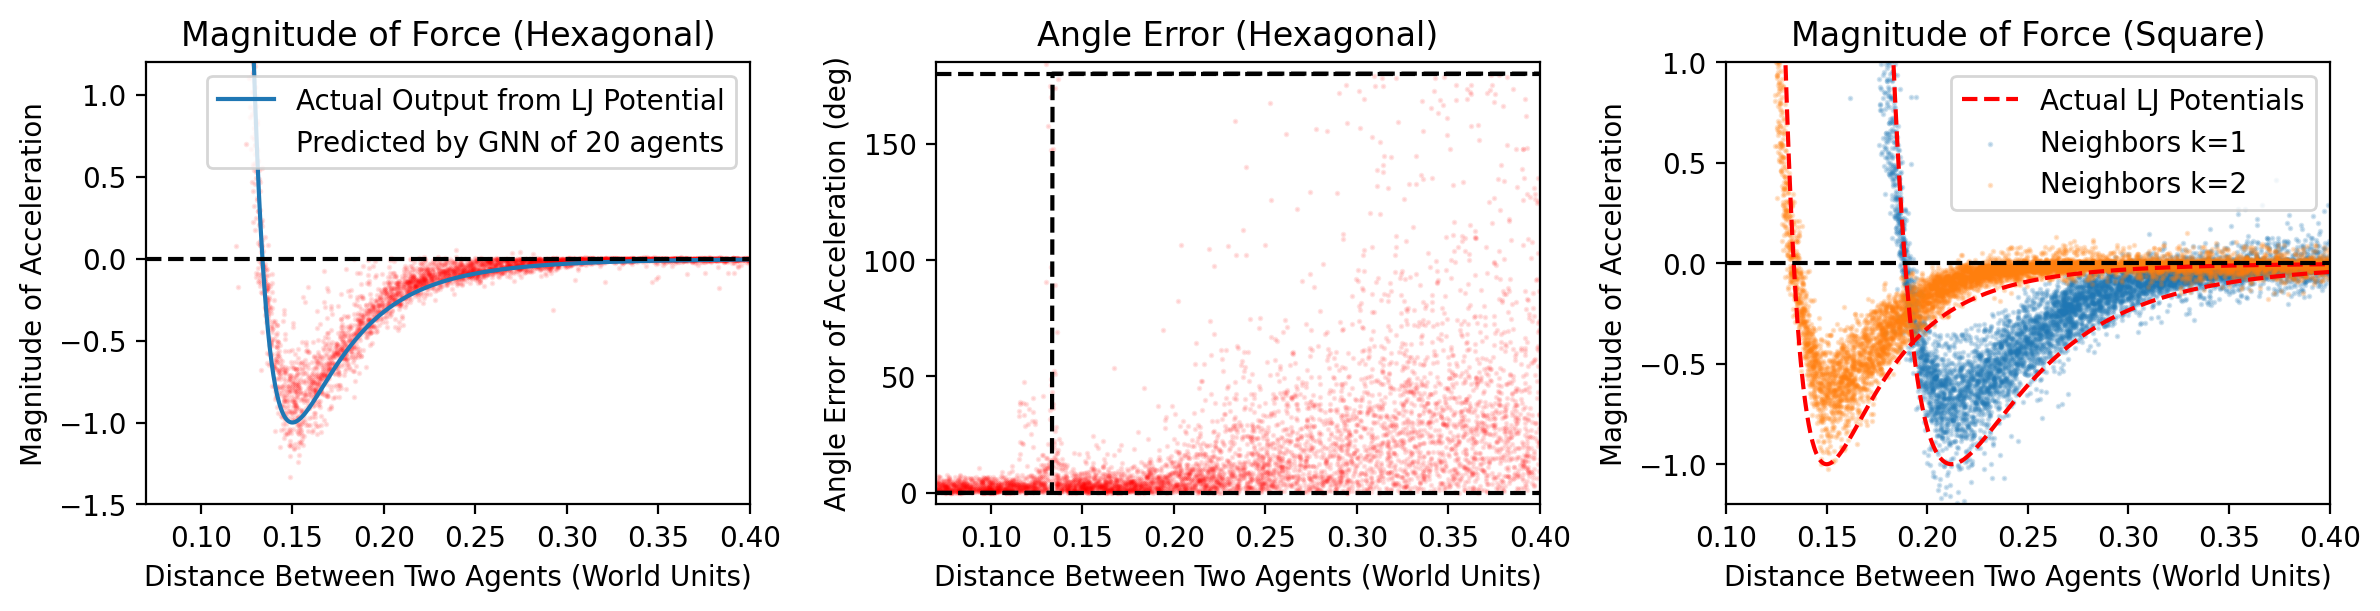

In [10]:
import math

mod = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=edge_idx, aggr=aggr).to(device)
mod.load_state_dict(torch.load('./models/MULTIMODELNUM0.mod'))
mod.eval()
mod.to('cpu')

xs = 0.07
xe = 0.4


MULT = 1
TARGET_DIST = 0.15 
DIP = 1 


def lj(x, e):
    
    dist = math.sqrt(((x[1][0]-x[0][0])**2)+((x[1][1]-x[0][1])**2))
    epsilon = DIP*MULT
    sigma = (TARGET_DIST*MULT)/(2**(1/6))
    mag = min((epsilon*4) * (pow((sigma/dist),12)-pow((sigma/dist),6)), 10)
    
    angle = math.pi
    if mag > 0:
        angle = 0
    
    return mag, angle
    
    
numScatter = 5000
numPoints = 1000
delta = (1/numPoints)*(xe-xs)

plotDataX = []
plotDataPredY = []
plotDataPredA = []
plotDataPredX = []
plotDataActY = []
plotDataActA = []
plotDataEqnY = []


for i in range(numPoints):
    
    data = [[0, 0] for _ in range(30)]
    xVal = delta*i+delta + xs
    data[1] = [xVal, 0]
    plotDataX.append(xVal)
    
    e1 = [0, 1]
    e2 = [1, 0]
    
    x = torch.tensor(data, dtype=torch.float)
    e = torch.tensor([e1, e2], dtype=torch.long)
    
    actualMag, actualAng = lj(x, e)
    
    
    plotDataActY.append(actualMag)#abs(actualMag))
    plotDataActA.append(math.degrees(actualAng))
    
    
    
pois = []

for i in range(numScatter):
    
    data = [[0, 0] for _ in range(20)]
    ox = random()
    oy = random()
    d = (random()*(xe-xs)+xs)
    a = random() * (2*math.pi)
    no = ox + d*math.cos(a)
    ny = oy + d*math.sin(a)
    
    data[0] = [ox, oy]
    data[1] = [no, ny]
    e1 = [0, 1]
    e2 = [1, 0]
    
    x = torch.tensor(data, dtype=torch.float)
    e = torch.tensor([e1, e2], dtype=torch.long)
    pred = mod(x, e)
    ljMag, ljAng = lj(x, e)
    pois.append([ox, oy, no, ny, pred[0][0], pred[0][1], d])
    
    mag = math.sqrt((pred[0][0])**2 + (pred[0][1])**2)
    ang = abs(math.degrees(math.atan2(pred[0][1], pred[0][0]) - math.atan2(oy-ny, ox-no)))
    
    
    
    actAng  = math.degrees(ljAng)
       
    if ang < 90: # clip ang to 0
        mag = mag
    else: # clip ang to 180
        mag = -mag
    
            
    plotDataPredX.append(d)
    plotDataPredA.append(abs(actAng-ang))
    plotDataPredY.append(mag)
#    plotDataEqnY.append(eqnMag)

    
plt.rcParams['figure.figsize'] = [12, 3]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower


fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ys = -1.5* MULT
ye = 1.2*MULT

ax1.plot(plotDataX, plotDataActY, label='Actual Output from LJ Potential')
ax1.scatter(plotDataPredX, plotDataPredY, s=1, color=[1, 0, 0], alpha=0.1, label='Predicted by GNN of 20 agents')
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.plot([xs, xe], [0, 0], 'k--')
ax1.legend()
ax1.set_xlabel("Distance Between Two Agents (World Units)")
ax1.set_ylabel("Magnitude of Acceleration")


import pickle
pickle.dump({'dist':plotDataPredX, 'mag':plotDataPredY}, open("GNNOutputData.p", 'wb'))

ax2.plot(plotDataX, plotDataActA, 'k--')
ax2.scatter(plotDataPredX, plotDataPredA, s=1, color=[1, 0, 0], alpha=0.1, label='Predicted by GNN of 20 agents')
ax2.set_xlim([xs, xe])
ax2.set_ylim([-5, 185])
ax2.plot([xs, xe], [0, 0], 'k--')
ax2.plot([xs, xe], [180, 180], 'k--')
ax2.set_xlabel("Distance Between Two Agents (World Units)")
ax2.set_ylabel("Angle Error of Acceleration (deg)")

minDist = 0.1
maxDist = 0.4
ys= -1.2
ye = 1

fig5data = pickle.load(open('figure5data.p', "rb"))
scatterX = fig5data["scatterX"]
scatterY = fig5data["scatterY"]
scatterY2 = fig5data["scatterY2"]
ljX = fig5data["ljX"]
ljY = fig5data["ljY"]
ljY2 = fig5data["ljY2"]

ax3.plot([0.5, 0.5], [ys, ye], 'k--')
ax3.set_xlabel("Distance Between Two Agents (World Units)")
ax3.set_ylabel("Magnitude of Acceleration")
ax3.set_xlim([minDist, maxDist])
ax3.set_ylim([ys, ye])
ax3.scatter(scatterX, scatterY, s=1, alpha=0.2, label='Neighbors k=1')
ax3.scatter(scatterX, scatterY2, s=1, alpha=0.2, label='Neighbors k=2')
ax3.plot(ljX, ljY, 'r--', label='Actual LJ Potentials')
ax3.plot(ljX, ljY2, 'r--')
ax3.plot([minDist, maxDist], [0, 0], 'k--')
ax3.legend()

plt.tight_layout()

ax1.set_title('Magnitude of Force (Hexagonal)')
ax2.set_title('Angle Error (Hexagonal)')
ax3.set_title('Magnitude of Force (Square)')
plt.savefig("fig1.pdf", bbox_inches='tight')



for dataPoint in range(numScatter):
    # zero crossing is 0.13363
    if pois[dataPoint][6] < 0.13367 and pois[dataPoint][6] > 0.13361:
        fig, ax3 = plt.subplots(1)
        fig.suptitle('Simulation with mag of ' + str(round(math.sqrt(pow(pois[dataPoint][4], 2) + pow(pois[dataPoint][5], 2)), 4)) + ' and distance of ' + str(round(pois[dataPoint][6], 4)))

        ax3.scatter([pois[dataPoint][0]], [pois[dataPoint][1]], s=50, color=[1, 0, 0], label='robot 0')
        ax3.scatter([pois[dataPoint][2]], [pois[dataPoint][3]], s=50, color=[0, 1, 0], label='robot 1')
        ax3.plot([pois[dataPoint][0], pois[dataPoint][0]+pois[dataPoint][4]], 
                 [pois[dataPoint][1], pois[dataPoint][1]+pois[dataPoint][5]])
        ax3.set_xlim([-0.5, 1.5])
        ax3.set_ylim([-0.5, 1.5])
        ax3.plot([0, 1], [0, 0], 'k--')
        ax3.plot([0, 1], [1, 1], 'k--')
        ax3.plot([0, 0], [0, 1], 'k--')
        ax3.plot([1, 1], [0, 1], 'k--')
        plt.xlabel("Distance Between Two Agents")
        plt.ylabel("Angle Error of Acceleration (deg)")
        break

        


In [21]:
sympify(c, locals=sympy_mappings)

(3.480762*x0 - 1.10581554991408)*((x0 - 1.1350316)/(x0 - 0.26352918) + 2.3512678)

/home/stephen/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


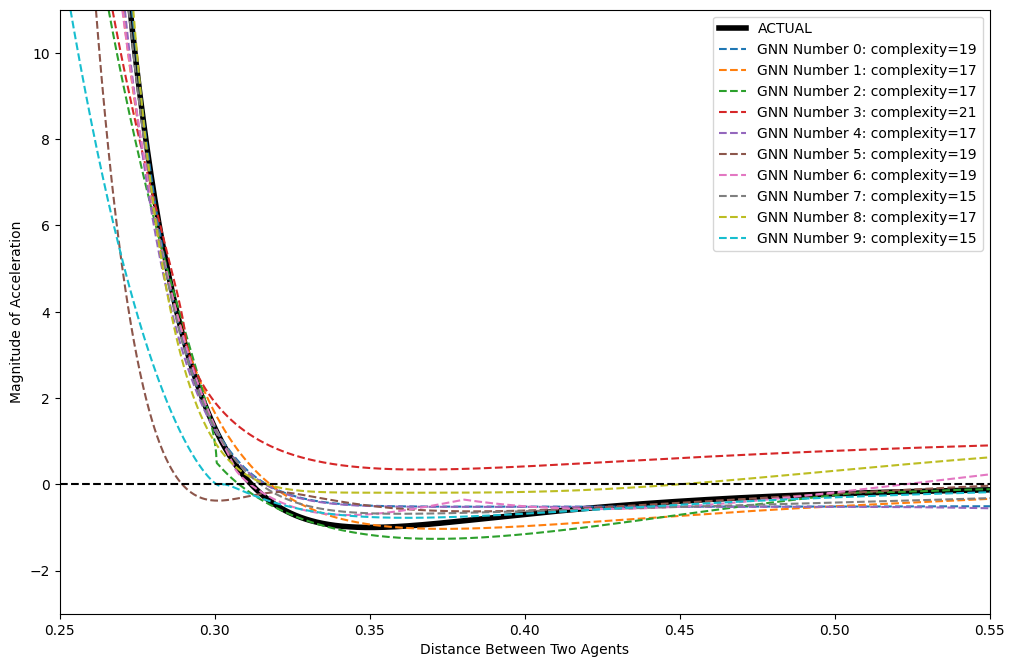

In [38]:
import pickle
from sympy import lambdify, sympify
import matplotlib.pyplot as plt
import math
from copy import deepcopy as copy


def lj(dist):

    MULT = 1
    TARGET_DIST = 0.35 
    DIP = 1 
    
    epsilon = DIP*MULT
    sigma = (TARGET_DIST*MULT)/(2**(1/6))
    mag = min((epsilon*4) * (pow((sigma/dist),12)-pow((sigma/dist),6)), 20)
    
    angle = math.pi
    if mag > 0:
        angle = 0
    
    return mag, angle
    

equations = pickle.load(open('./PySR/ALLEQUATIONS.p', 'rb'))
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

cmp = []
lambdas = []
actual = []
x = []
ds = [[] for i in range(len(equations))]
gran = 10000

eqs = []
first = True
for j in range(len(equations)):
    if j >=1:
        first = False
    eq = equations[j].head(1)
    eqVal = eq['Equation'].values[0]
    cmp.append(eq['Complexity'].values[0])
    eqs.append(eqVal)
    le = lambdify('x0', sympify(eqVal, locals=sympy_mappings))
    
    lambdas.append(le)
    
    for i in range(gran):
        if first:
            x.append(i/gran + 1/gran)
            m, a = lj(i/gran + 1/gran)
            actual.append(m)
        try:
            ds[j].append(le(i/gran + 1/gran))
        except OverflowError as error:
            ds[j].append(-1)
        
        
        
plt.plot(x, actual, 'k-', linewidth=4, label='ACTUAL')
for i in range(len(lambdas)):
    plt.plot(x, ds[i], '--', label='GNN Number '+str(i)+ ": complexity="+str(cmp[i]))
    
plt.ylim([-3, 11])
plt.xlim([0.25, 0.55])
plt.plot([0.25, 0.75], [0, 0], 'k--')
plt.xlabel("Distance Between Two Agents")
plt.ylabel("Magnitude of Acceleration")
plt.legend()

    

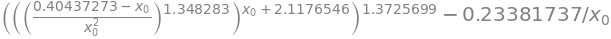

In [19]:
from sympy import simplify
sympify(eqs[0], locals=sympy_mappings)

In [32]:
from sympy import simplify
print(sympify(eqs[1], locals=sympy_mappings))

-2.8819533e-5**(x0 - 0.40703288) + (-2.356177 + 1.127167/x0)**(0.19580759**x0 + x0**(-1.0627089)) + 0.22261332


In [22]:
from sympy import simplify
sympify(eqs[2], locals=sympy_mappings)

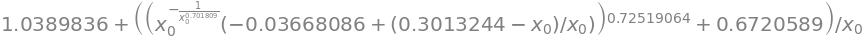

In [23]:
from sympy import simplify
sympify(eqs[3], locals=sympy_mappings)

In [24]:
from sympy import simplify
sympify(eqs[4], locals=sympy_mappings)

In [25]:
from sympy import simplify
sympify(eqs[5], locals=sympy_mappings)

In [27]:
from sympy import simplify
sympify(eqs[6], locals=sympy_mappings)

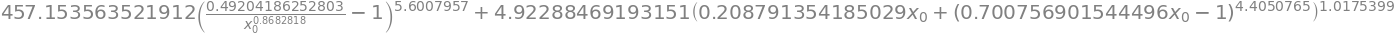

In [28]:
from sympy import simplify
sympify(eqs[7], locals=sympy_mappings)

In [29]:
from sympy import simplify
sympify(eqs[8], locals=sympy_mappings)

In [30]:
from sympy import simplify
sympify(eqs[9], locals=sympy_mappings)

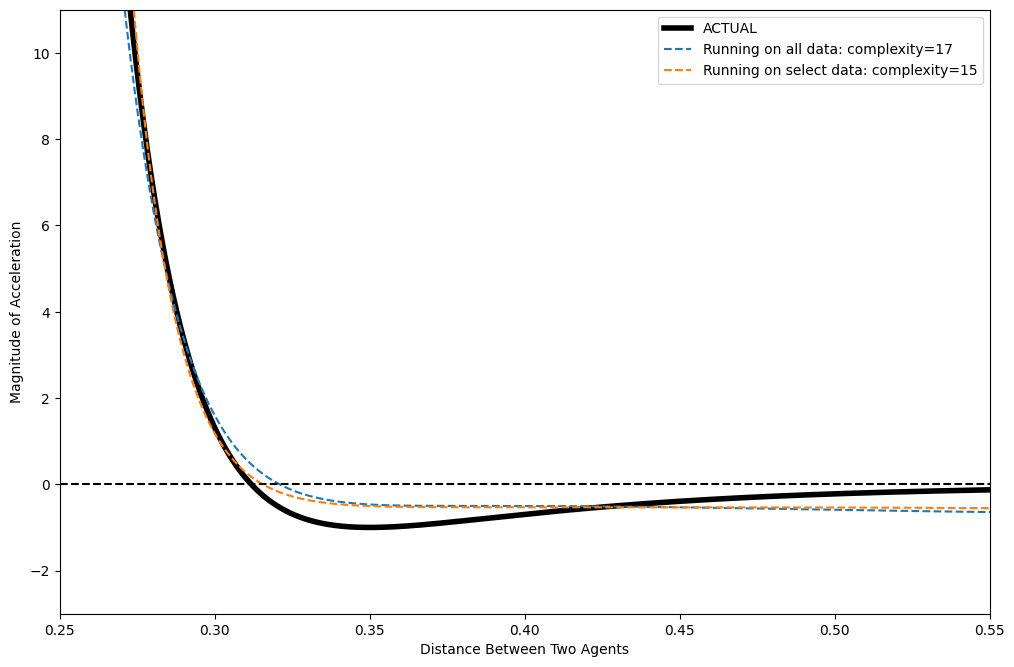

In [40]:
import pickle
from sympy import lambdify, sympify
import matplotlib.pyplot as plt
import math
from copy import deepcopy as copy


def lj(dist):

    MULT = 1
    TARGET_DIST = 0.35 
    DIP = 1 
    
    epsilon = DIP*MULT
    sigma = (TARGET_DIST*MULT)/(2**(1/6))
    mag = min((epsilon*4) * (pow((sigma/dist),12)-pow((sigma/dist),6)), 20)
    
    angle = math.pi
    if mag > 0:
        angle = 0
    
    return mag, angle
    

allDataEq = pickle.load(open('./PySR/ALLDATAEQ.p', 'rb'))
selDataEq = pickle.load(open('./PySR/SELDATAEQ.p', 'rb'))
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

cmp = []
actual = []
x = []
gran = 10000

allEq = allDataEq.head(1)
selEq = selDataEq.head(1)
AeqVal = allEq['Equation'].values[0]
SeqVal = selEq['Equation'].values[0]

aVals = []
sVals = []

cmp.append(allEq['Complexity'].values[0])
cmp.append(selEq['Complexity'].values[0])

allLe = lambdify('x0', sympify(AeqVal, locals=sympy_mappings))
selLe = lambdify('x0', sympify(SeqVal, locals=sympy_mappings))

for i in range(gran):
    x.append(i/gran + 1/gran)
    m, a = lj(i/gran + 1/gran)
    actual.append(m)
    try:
        aVals.append(allLe(i/gran + 1/gran))
    except OverflowError as error:
        aVals.append(-1)
        
    try:
        sVals.append(selLe(i/gran + 1/gran))
    except OverflowError as error:
        sVals.append(-1)
        
        
plt.plot(x, actual, 'k-', linewidth=4, label='ACTUAL')
plt.plot(x, aVals, '--', label='Running on all data: complexity='+str(cmp[0]))
plt.plot(x, sVals, '--', label='Running on select data: complexity='+str(cmp[1]))
    
plt.ylim([-3, 11])
plt.xlim([0.25, 0.55])
plt.plot([0.25, 0.75], [0, 0], 'k--')
plt.xlabel("Distance Between Two Agents")
plt.ylabel("Magnitude of Acceleration")
plt.legend()

In [36]:
from sympy import simplify
sympify(AeqVal, locals=sympy_mappings)

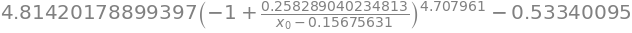

In [37]:
from sympy import simplify
sympify(SeqVal, locals=sympy_mappings)